In [47]:
import numpy as np
import pandas as pd
import random
from math import radians, sin, cos, sqrt, atan2
from sklearn.cluster import KMeans


def haversine(p1, p2):
    R = 6371.0
    lat1, lon1 = radians(p1[0]), radians(p1[1])
    lat2, lon2 = radians(p2[0]), radians(p2[1])
    dlat, dlon = lat2 - lat1, lon2 - lon1
    a = sin(dlat/2)**2 + cos(lat1)*cos(lat2)*sin(dlon/2)**2
    return 2*R*atan2(sqrt(a), sqrt(1-a))

def preparar_datos(df):
    df = df.copy().reset_index(drop=True)
    df['nombre'] = [chr(ord('A')+i) for i in range(len(df))]
    n = len(df)
    coords = list(zip(df['latitude'], df['longitude']))
    D = np.zeros((n, n), float)
    for i in range(n):
        for j in range(n):
            if i != j:
                D[i, j] = haversine(coords[i], coords[j])
    return df, D, 0


def separar_por_separadores(chrom, k):
    rutas, actual = [], []
    for g in chrom:
        if g == -1:
            rutas.append(actual); actual = []
        else:
            actual.append(g)
    rutas.append(actual)
    if len(rutas) < k:
        rutas += [[] for _ in range(k - len(rutas))]
    elif len(rutas) > k:
        extra = []
        for r in rutas[k-1:]:
            extra += r
        rutas = rutas[:k-1] + [rutas[k-1] + extra]
    return rutas[:k]

def costo_ruta(idx_ruta, D, deposito=0):
    if not idx_ruta:
        return 0.0
    c = D[deposito, idx_ruta[0]]
    for i in range(len(idx_ruta)-1):
        c += D[idx_ruta[i], idx_ruta[i+1]]
    c += D[idx_ruta[-1], deposito]
    return c

def capacidad_penalidad(rutas, demanda, Q, lambda_cap=1000.0):
    if (demanda is None) or (Q is None):
        return 0.0
    pen = 0.0
    for r in rutas:
        carga = sum(demanda[i] for i in r)
        if carga > Q:
            pen += lambda_cap * (carga - Q)
    return pen

def costo_total_VRP(chrom, D, k, demanda=None, Q=None, deposito=0, lambda_cap=1000.0):
    rutas = separar_por_separadores(chrom, k)
    dist = sum(costo_ruta(r, D, deposito) for r in rutas)
    pen = capacidad_penalidad(rutas, demanda, Q, lambda_cap=lambda_cap)
    return dist + pen, rutas

def split_por_capacidad(orden, k, demanda=None, Q=None):
    if (demanda is None) or (Q is None):
        n = len(orden)
        base = n // k
        rutas = []
        ptr = 0
        for v in range(k):
            extra = 1 if v < (n % k) else 0
            rutas.append(orden[ptr:ptr+base+extra])
            ptr += base + extra
    else:
        rutas, carga, actual = [], 0, []
        for c in orden:
            d = demanda[c]
            if carga + d <= Q or len(actual) == 0:
                actual.append(c); carga += d
            else:
                rutas.append(actual)
                actual, carga = [c], d
        rutas.append(actual)
        if len(rutas) < k:
            rutas += [[] for _ in range(k-len(rutas))]
        if len(rutas) > k:
            extra = []
            for r in rutas[k-1:]:
                extra += r
            rutas = rutas[:k-1] + [rutas[k-1]+extra]

    chrom = []
    for v in range(k):
        chrom += rutas[v]
        if v < k-1:
            chrom.append(-1)
    return chrom


def crear_individuo_VRP(n, k, demanda=None, Q=None, deposito=0):
    clientes = [i for i in range(n) if i != deposito]
    random.shuffle(clientes)
    return split_por_capacidad(clientes, k, demanda, Q)

def crear_poblacion_VRP(tam, n, k, demanda=None, Q=None, deposito=0):
    return [crear_individuo_VRP(n, k, demanda, Q, deposito) for _ in range(tam)]

def extraer_orden_clientes(chrom):
    return [g for g in chrom if g != -1]

def crossover_OX_orden(o1, o2):
    n = len(o1)
    a, b = sorted(random.sample(range(n), 2))
    hijo = [None]*n
    hijo[a:b+1] = o1[a:b+1]
    pos = (b+1) % n
    for i in range(n):
        g = o2[(b+1+i) % n]
        if g not in hijo:
            hijo[pos] = g
            pos = (pos+1) % n
    return hijo

def crossover_VRP(p1, p2, k, demanda=None, Q=None):
    o1, o2 = extraer_orden_clientes(p1), extraer_orden_clientes(p2)
    hijo_orden = crossover_OX_orden(o1, o2)
    return split_por_capacidad(hijo_orden, k, demanda, Q)

def mutacion_swap_VRP(chrom, prob=0.1, k=2, demanda=None, Q=None):
    if random.random() < prob:
        orden = extraer_orden_clientes(chrom)
        if len(orden) >= 2:
            i, j = random.sample(range(len(orden)), 2)
            orden[i], orden[j] = orden[j], orden[i]
        chrom = split_por_capacidad(orden, k, demanda, Q)
    return chrom

def seleccion_torneo(poblacion, costos, k=3):
    cand = random.sample(range(len(poblacion)), k)
    cand.sort(key=lambda idx: costos[idx])
    return poblacion[cand[0]]


def genetico_vrp(df,
                 k_vehiculos=3,
                 demanda=None,
                 Q=None,
                 tam_poblacion=120,
                 generaciones=600,
                 elite=0.1,
                 p_mut=0.15,
                 torneo_k=3,
                 lambda_cap=1000.0,
                 seed=None):
    if seed is not None:
        random.seed(seed); np.random.seed(seed)

    df, D, deposito = preparar_datos(df)
    n = len(df)

    if demanda is None:
        demanda = [0]*n
    if demanda[0] != 0:
        demanda[0] = 0

    pobl = crear_poblacion_VRP(tam_poblacion, n, k_vehiculos, demanda, Q, deposito)
    costos = [costo_total_VRP(ch, D, k_vehiculos, demanda, Q, deposito, lambda_cap)[0] for ch in pobl]

    num_elite = max(1, int(elite * tam_poblacion))
    best_idx = int(np.argmin(costos))
    best_chrom = pobl[best_idx]
    best_cost = costos[best_idx]
    history = [best_cost]

    for _ in range(generaciones):
        orden = np.argsort(costos)
        nueva = [pobl[i] for i in orden[:num_elite]]

        while len(nueva) < tam_poblacion:
            p1 = seleccion_torneo(pobl, costos, torneo_k)
            p2 = seleccion_torneo(pobl, costos, torneo_k)
            hijo = crossover_VRP(p1, p2, k_vehiculos, demanda, Q)
            hijo = mutacion_swap_VRP(hijo, p_mut, k_vehiculos, demanda, Q)
            nueva.append(hijo)

        pobl = nueva
        costos = [costo_total_VRP(ch, D, k_vehiculos, demanda, Q, deposito, lambda_cap)[0] for ch in pobl]

        i_best = int(np.argmin(costos))
        if costos[i_best] < best_cost:
            best_cost = costos[i_best]
            best_chrom = pobl[i_best]
        history.append(best_cost)

    best_cost, rutas_idx = costo_total_VRP(best_chrom, D, k_vehiculos, demanda, Q, deposito, lambda_cap)
    rutas_nombres = [[df.loc[i, 'nombre'] for i in r] for r in rutas_idx]
    rutas_nombres_depot = [
        [df.loc[deposito,'nombre']] + r + [df.loc[deposito,'nombre']] for r in rutas_nombres
    ]
    return {
        'mejor_costo_km': best_cost,
        'rutas_indices': rutas_idx,
        'rutas_nombres': rutas_nombres_depot,
        'historial': history,
        'matriz_dist': D,
        'df': df
    }

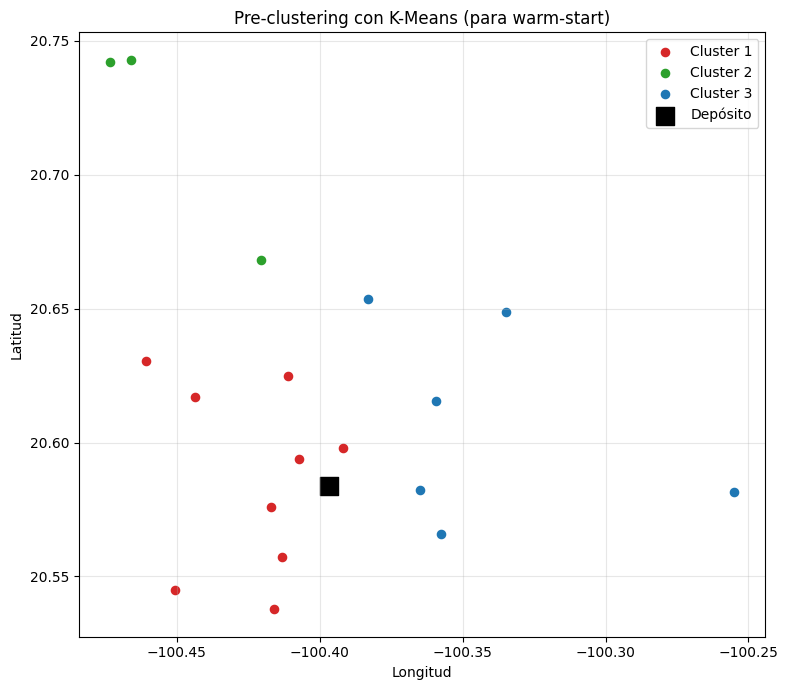

Semilla (permutación de clientes): [9, 7, 13, 18, 4, 3, 2, 12, 6, 17, 1, 14, 5, 15, 8] ...


In [48]:
k = 3
deposito = 0
X = df.loc[1:, ['longitude','latitude']].values
kmeans = KMeans(n_clusters=k, n_init=10, random_state=42)
labels = kmeans.fit_predict(X)

clusters = {c: [] for c in range(k)}
for idx_global, c in zip(range(1, len(df)), labels):
    clusters[c].append(idx_global)

colors = ['tab:red','tab:green','tab:blue','tab:orange','tab:purple']
plt.figure(figsize=(8,7))
for c, idxs in clusters.items():
    plt.scatter(df.loc[idxs, 'longitude'], df.loc[idxs, 'latitude'],
                s=35, color=colors[c % len(colors)], label=f'Cluster {c+1}')
plt.scatter([df.loc[deposito,'longitude']], [df.loc[deposito,'latitude']],
            s=160, marker='s', color='black', label='Depósito')
plt.title("Pre-clustering con K-Means (para warm-start)")
plt.xlabel("Longitud"); plt.ylabel("Latitud")
plt.legend(); plt.grid(True, alpha=0.3); plt.tight_layout()
plt.show()

def ordenar_por_angulo(idxs):
    pts = df.loc[idxs, ['longitude','latitude']].values
    cx, cy = pts[:,0].mean(), pts[:,1].mean()
    ang = np.arctan2(pts[:,1]-cy, pts[:,0]-cx)          # ángulo
    orden_local = [i for _, i in sorted(zip(ang, idxs), key=lambda t: t[0])]
    return orden_local

dep_xy = df.loc[deposito, ['longitude','latitude']].values
centroides = {c: df.loc[idxs, ['longitude','latitude']].mean().values for c, idxs in clusters.items()}
orden_clusters = sorted(clusters.keys(),
                        key=lambda c: np.linalg.norm(centroides[c]-dep_xy))

semilla_perm = []
for c in orden_clusters:
    semilla_perm += ordenar_por_angulo(clusters[c])

print("Semilla (permutación de clientes):", semilla_perm[:15], "...")


Mejor costo total (km): 100.00

Vehículo 1: A -> D -> E -> I -> F -> O -> B -> R -> A
Vehículo 2: A -> M -> G -> L -> K -> Q -> P -> C -> A
Vehículo 3: A -> N -> H -> J -> S -> A


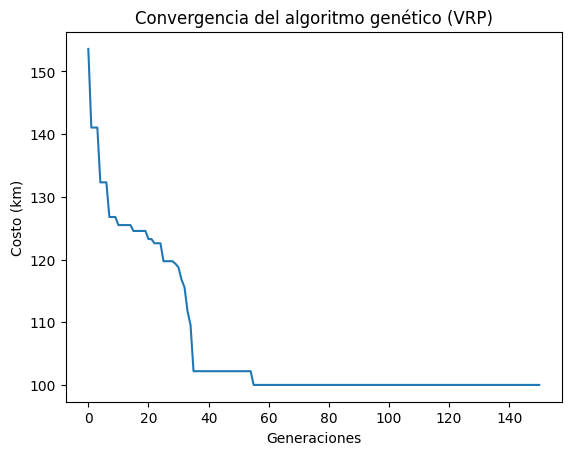

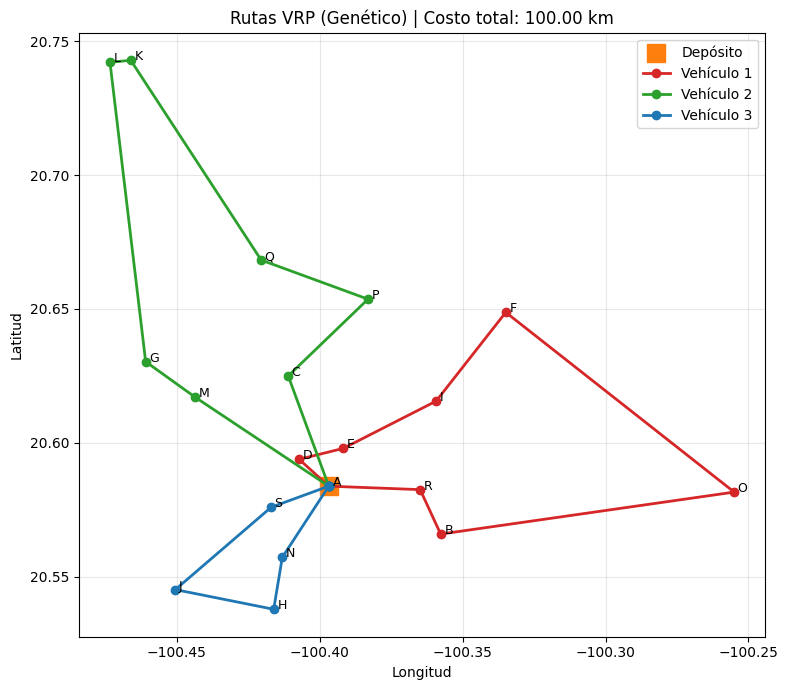

In [49]:
res = genetico_vrp(df, k_vehiculos=3, demanda=demanda, Q=150,
                   generaciones=150, tam_poblacion=90, seed=4)

print(f"\nMejor costo total (km): {res['mejor_costo_km']:.2f}\n")
for i, ruta in enumerate(res['rutas_nombres'], 1):
    print(f"Vehículo {i}: {' -> '.join(ruta)}")

plt.plot(res['historial'])
plt.xlabel("Generaciones"); plt.ylabel("Costo (km)")
plt.title("Convergencia del algoritmo genético (VRP)")
plt.show()

plot_vrp_routes(df, res)